<a href="https://colab.research.google.com/github/haimin777/tools/blob/master/CheckPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.3.0
!pip install -U git+https://github.com/haimin777/keras-ocr.git
!pip install -U opencv-python # We need the most recent version of OpenCV.
 
!pip install tensorflow-addons==0.11.2
 
%tensorflow_version 2.x
from IPython.display import clear_output
clear_output()

In [4]:
import zipfile
import datetime
import string
import glob
import math
import os
import shutil as sh
 
import typing
import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow as tf
import sklearn.model_selection
 
from tensorflow import keras
import keras_ocr
import numpy as np
import pandas as pd
 
from xml.etree import ElementTree
from xml.etree.ElementTree import XMLParser
from numpy import array
 
import cv2
from PIL import Image
#assert tf.test.is_gpu_available()
 
#import tensorflow_addons as tfa

In [5]:
 
#import tools.qacheck as qacheck
keras_ocr.tools.initialize_image_ops()

/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.4.0 and trying to load a custom op (custom_ops/image/_image_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are not supported.

The last solution is to fin

tensorflow.python.framework.errors_impl.NotFoundError()

In [17]:
# Check test files
 
if not os.path.exists('GGPokerOk_GT_3_cat'):
 
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EvLUgQeOLLOpUa9Fq5O_6JBAzYSZiI1D' -O GGPokerOk_GT_3_cat.zip
    !unzip -q GGPokerOk_GT_3_cat.zip

--2021-01-25 10:43:50--  https://docs.google.com/uc?export=download&id=1EvLUgQeOLLOpUa9Fq5O_6JBAzYSZiI1D
Resolving docs.google.com (docs.google.com)... 64.233.189.102, 64.233.189.113, 64.233.189.101, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pct5oe0t9heq5cjbdbudsnevnupu9686/1611571425000/08605806127936840926/*/1EvLUgQeOLLOpUa9Fq5O_6JBAzYSZiI1D?e=download [following]
--2021-01-25 10:43:53--  https://doc-0k-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pct5oe0t9heq5cjbdbudsnevnupu9686/1611571425000/08605806127936840926/*/1EvLUgQeOLLOpUa9Fq5O_6JBAzYSZiI1D?e=download
Resolving doc-0k-4o-docs.googleusercontent.com (doc-0k-4o-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0k-4o-docs.googleusercontent.com (doc-0k-4o-d

In [18]:
# download backbone weights

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1L7j9tUKmalOS02411ob58UW1isNtDWFh' -O craft_mlt_25k.h5
!mkdir /root/.keras-ocr 
!mv craft_mlt_25k.h5 /root/.keras-ocr


--2021-01-25 10:44:00--  https://docs.google.com/uc?export=download&id=1L7j9tUKmalOS02411ob58UW1isNtDWFh
Resolving docs.google.com (docs.google.com)... 64.233.189.102, 64.233.189.113, 64.233.189.101, ...
Connecting to docs.google.com (docs.google.com)|64.233.189.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m5rgrknnevjdjv3io0b3sei66a1ibkee/1611571425000/08605806127936840926/*/1L7j9tUKmalOS02411ob58UW1isNtDWFh?e=download [following]
--2021-01-25 10:44:03--  https://doc-08-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/m5rgrknnevjdjv3io0b3sei66a1ibkee/1611571425000/08605806127936840926/*/1L7j9tUKmalOS02411ob58UW1isNtDWFh?e=download
Resolving doc-08-4o-docs.googleusercontent.com (doc-08-4o-docs.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-08-4o-docs.googleusercontent.com (doc-08-4o-d

In [19]:
test_images_full = glob.glob('GGPokerOk_GT_3_cat/*jpg')
test_xmls = glob.glob('GGPokerOk_GT_3_cat/*xml')
 
test_xmls.sort()
test_images_full.sort()
test_images_full[:2], test_xmls[:2]

(['GGPokerOk_GT_3_cat/image0000000002.jpg',
  'GGPokerOk_GT_3_cat/image0000000195.jpg'],
 ['GGPokerOk_GT_3_cat/image0000000002.xml',
  'GGPokerOk_GT_3_cat/image0000000195.xml'])

In [21]:
# Paths to weights
#recognizer_weigths = glob.glob('/content/drive/My Drive/AIgym/keras-ocr/trained_weights/re*-01-18T16*.h5')  # - for recognizer check
recognizer_weigths = glob.glob('/content/drive/My Drive/AIgym/keras-ocr/trained_weights/re*J_*T*.h5') 
 
#detect_weights = glob.glob('/content/drive/My Drive/AIgym/keras-ocr/trained_weights/d*12-29T13:38*.h5') # - for recognizer check
detect_weights = glob.glob('/content/drive/My Drive/AIgym/keras-ocr/trained_weights/det*2021-01-25T*.h5')

detect_weights, recognizer_weigths

(['/content/drive/My Drive/AIgym/keras-ocr/trained_weights/det_DatasetVin_Exper_H_colab2021-01-25T06:48:18.635191.h5',
  '/content/drive/My Drive/AIgym/keras-ocr/trained_weights/det_DatasetVin_Exper_H_colab2021-01-25T10:39:46.486445.h5'],
 ['/content/drive/My Drive/AIgym/keras-ocr/trained_weights/rec_SynData_J_DigitsText_DigitsDoll_filtred_2020-11-13T09:42:34.756546.h5'])

In [13]:
!rm '/content/drive/My Drive/AIgym/keras-ocr/trained_weights/det_DatasetVin_Exper_H_colab2021-01-25T06:46:16.341879.h5'

In [22]:
#create model and load weights
 
alphabet = string.digits + string.ascii_letters + '$%./ ♥♠♦♣'  #'$%. '
 
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))
 
one_graph_model = keras_ocr.tools.create_one_grap_model(detect_weights[-1], recognizer_weigths[-1], recognizer_alphabet)
clear_output()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


NotFoundError: ignored

In [ ]:
  
one_graph_pipeline = keras_ocr.tools.OneGraphPipeline(one_graph_model, recognizer_alphabet)
 
qa_df_one = keras_ocr.tools.quality_df(test_images_full, test_xmls,  one_graph_pipeline, one_graph=True)
 
qa_df_one.describe()

In [ ]:
# print ids of images with minimal cards accuracy
qa_df_one[qa_df_one['money_acc'] <= 0.8]

,image_name,card_acc,card_recall,money_acc,money_recall,other_acc,other_recall
20,image0000000645.xml,0.75,0.14,0.71,0.50,0.57,0.26
21,image0000000681.xml,1.00,0.00,0.78,0.36,0.57,0.23
23,image0000000779.xml,0.82,0.10,0.80,0.67,0.43,0.31
26,image0000000977.xml,1.00,0.09,0.80,0.60,0.83,0.10


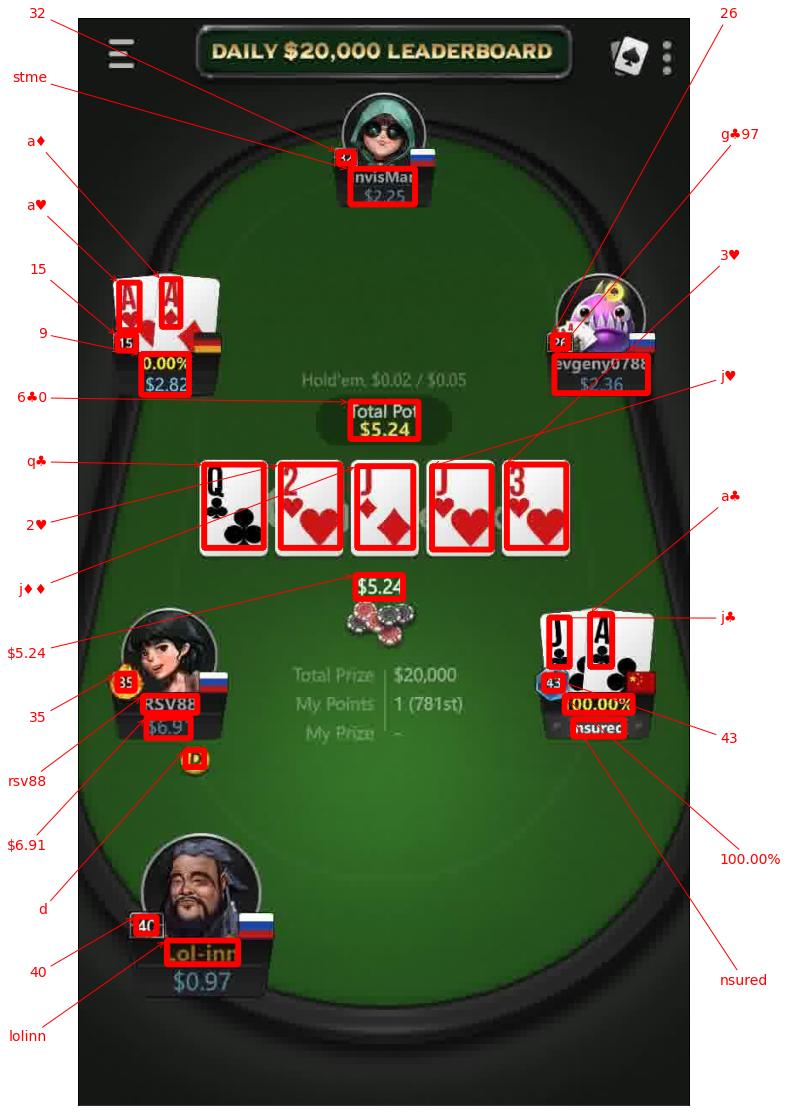

In [28]:
# wisualize given results for some ids
n = 20
inp = keras_ocr.tools.read(test_images_full[n]) 
img = inp
#img = cv2.resize(img, (405, 720))
inp = np.expand_dims(img, 0)
prediction_groups_one = one_graph_pipeline.recognize(inp)
fig, axs = plt.subplots(nrows=1, figsize=(20, 20))
keras_ocr.tools.drawAnnotations(img, predictions=prediction_groups_one[0], ax=axs)

In [ ]:
inp.shape

(1, 1280, 720, 3)

# Check results on train data

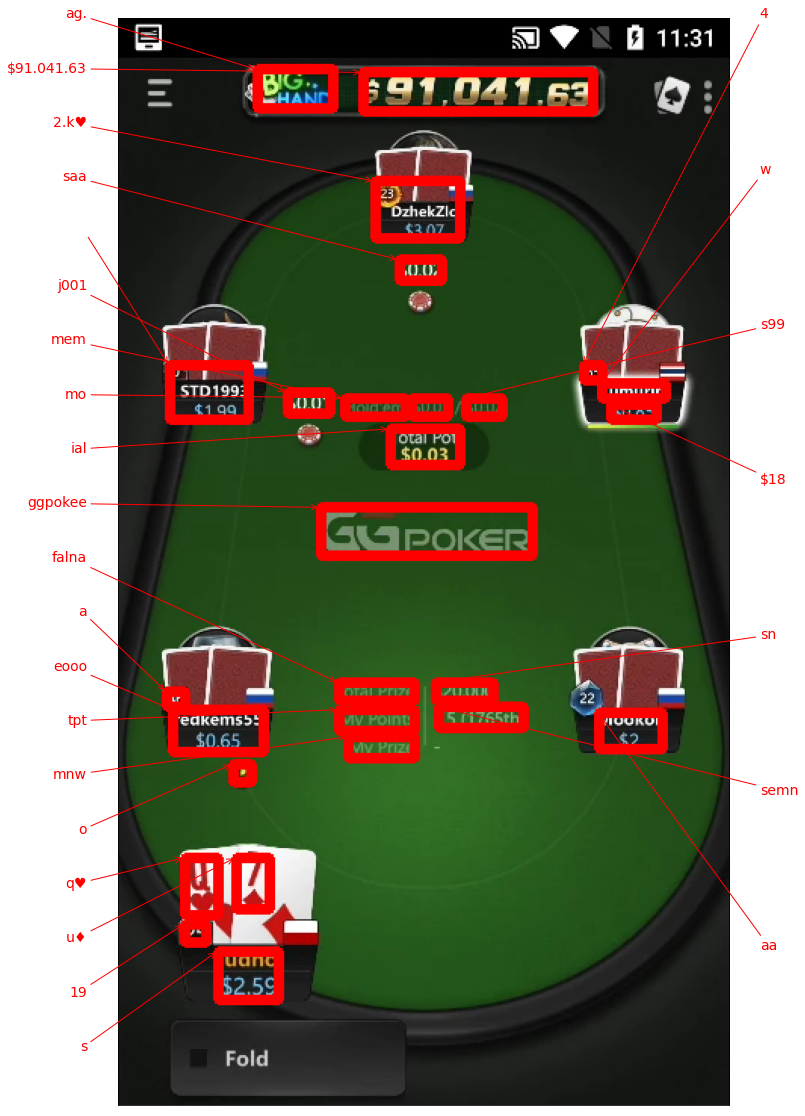

In [79]:
# wisualize given results for some ids
train_images = glob.glob('/content/drive/My Drive/AIgym/keras-ocr/GG_TrainDataset_cards_2+1_1/*p')

n = 5
inp = keras_ocr.tools.read(train_images[n]) 
img = inp
inp = np.expand_dims(inp, 0)
prediction_groups_one = one_graph_pipeline.recognize(inp)
fig, axs = plt.subplots(nrows=1, figsize=(20, 20))
keras_ocr.tools.drawAnnotations(img, predictions=prediction_groups_one[0], ax=axs)

In [12]:
inp.shape

(1, 720, 405, 3)

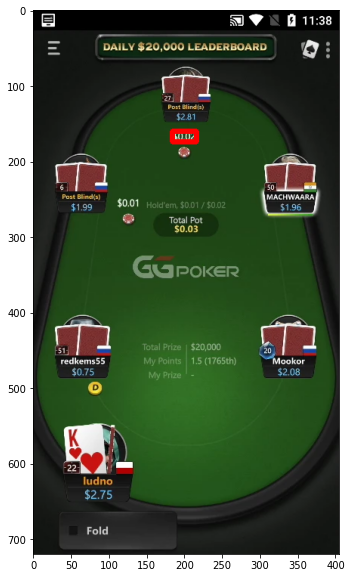

In [ ]:
train_images = glob.glob('/content/drive/My Drive/AIgym/keras-ocr/GG_TrainDataset_cards_2+1_1/*p')
n = 33
inp = keras_ocr.tools.read(train_images[n]) 
img = inp
inp = np.expand_dims(inp, 0)
prediction_groups_one = one_graph_pipeline.recognize(inp)

bboxes = [data[2] for data in prediction_groups_one]
plt.figure(figsize=(10,10))

#canvas = keras_ocr.tools.drawBoxes(image=img, boxes=bboxes, boxes_format='predictions')
keras_ocr.tools.drawAnnotations(img, predictions=prediction_groups_one[0], ax=axs)
plt.imshow(canvas)


In [ ]:
det = keras_ocr.detection.Detector()
det.model.summary()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Model: "functional_223"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
basenet.slice1.0 (Conv2D)       (None, None, None, 6 1792        input_67[0][0]                   
__________________________________________________________________________________________________
basenet.slice1.1 (BatchNormaliz (None, None, None, 6 256         basenet.slice1.0[0][0]           
__________________________________________________________________________________________________
basenet.slice1.2 (Activation)   (None, None, None, 6 0           basenet.slice1.1[0][0]           
_______________________________________

In [ ]:
prediction_groups_one [0]

[('$11.72', array([[250,  10],
         [350,  10],
         [350,  36],
         [250,  36]], dtype=int32)), ('$75.68', array([[378,  18],
         [480,  18],
         [480,  46],
         [378,  46]], dtype=int32)), ('$187.14', array([[  6,  20],
         [128,  20],
         [128,  48],
         [  6,  48]], dtype=int32)), ('iocu', array([[518,  38],
         [578,  38],
         [578,  60],
         [518,  60]], dtype=int32)), ('$$9.4', array([[270,  60],
         [354,  60],
         [354,  88],
         [270,  88]], dtype=int32)), ('dbd', array([[518,  68],
         [574,  68],
         [574,  94],
         [518,  94]], dtype=int32)), ('6♥', array([[158,  74],
         [216,  74],
         [216, 166],
         [158, 166]], dtype=int32)), ('$163.04', array([[ 10,  86],
         [132,  86],
         [132, 114],
         [ 10, 114]], dtype=int32)), ('vmxbt', array([[518, 100],
         [608, 100],
         [608, 126],
         [518, 126]], dtype=int32)), ('4♣', array([[390, 110],
 